# Net Radiation Calculation Example
The incoming radiation $K_{In}$ is important for a lot of processes in physical hydrology. See appendix D.2 for this

## Extraterrestrial Solar Radiation
For a given latitidue ($lat$) and day of year ($J$), we can estimate the radiation outside the earth. First we calcuate the day angle ($\Gamma$) 

$$ \Gamma = \frac{2 \pi (J-1)}{365} $$ 

Next we calculate the orbital eccentricity (r0/r) which is the square of the ratio of the average distance, r0, to the distance at any time, r. This is calculated as

$$ E0 = 1.000110 + 0.034221\cos(\Gamma􏰇) + 0.001280\sin(\Gamma􏰇) $$
$$ + 0.000719\cos(2\Gamma􏰇) + 0.000077*\sin(2\Gamma􏰇) $$

Next we need the solar declination ($\delta$), which is the angle between the plane of the equator and the rays of the sun; it is equal to the latitude at which the sun is directly overhead at noon.

$$ \delta􏰈 = 0.006918 – 0.399912\cos(\Gamma􏰇) + 0.070257\sin(􏰇\Gamma) – 0.006758\cos(2 \Gamma)$$
$$  + 0.000907 sin(2\Gamma􏰇) – 0.002697\cos(3\Gamma) + 0.00148\sin(3\Gamma􏰇)$$

And the hour that it will rise and set

$$ T_R = -\frac{ \cos^{-1}\left[-\tan(\delta)\tan(lat)\right]}{\omega} $$

$$ T_S = +\frac{ \cos^{-1}\left[-\tan(\delta)\tan(lat)\right]}{\omega} $$

These are then integrated over the day to get the total radiation at the top of atmosphere.


In [3]:
# Import numeric python and the plotting library
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Solar Constant
S = 4.910 # MJ/hr/m2
omega = 0.2618 # Angular velocity of earth [rad/hr]

# Example Point and Time
lat = 44.5704
doy = 274 # Oct 1
time = 12

# Day Angle Calculation
def getAngle(doy):
    dayAngle = 2 * np.pi * (doy-1)/365
    return dayAngle
print('dAngle',getAngle(doy))

# Declination
def getDec(doy):
    dAngle = getAngle(doy)
    declination = (0.006918 - 
         0.399912*np.cos(dAngle) + 
         0.070257*np.sin(dAngle) - 
         0.006758*np.cos(2*dAngle) + 
         0.000907*np.sin(2*dAngle) - 
         0.002697*np.cos(3*dAngle) + 
         0.00148* np.sin(3*dAngle))
    return declination
print('declination',getDec(doy))

# Orbital Eccentricity
def getEcc(doy):
    dAngle = getAngle(doy)
    ecc = (1.000110+
      0.034221*np.cos(dAngle)+
      0.001280*np.sin(dAngle)+
      0.000719*np.cos(2*dAngle)+
      0.000077*np.sin(2*dAngle))
    return ecc
print('E0:', getEcc(doy))

# Rise and Set time
def getTRTS(doy, lat):
    declination = getDec(doy)
    TR = -np.arccos(-np.tan(declination)*np.tan(lat))/omega
    TS = +np.arccos(-np.tan(declination)*np.tan(lat))/omega
    return TR, TS
print('TR, TS:',getTRTS(doy,lat))

# Daily Total Extraterrestrial Solar Radiation [MJ/day]
def getKE(doy,lat):
    declination = getDec(doy)
    ecc = getEcc(doy)
    TR, TS = getTRTS(doy,lat)
    KE = 2*S*ecc*(
        np.sin(lat)*np.sin(declination)*TS + 
        np.cos(lat)*np.cos(declination)*np.sin(omega*TS)/omega)
    return KE
print('KE',getKE(doy,lat))


dAngle 4.69947832564391
declination -0.05001654180216839
E0: 0.9976715311345575
TR, TS: (-5.872462497537448, 5.872462497537448)
KE 29.483025393557497


# Plot radiation in space and time
We want to show how in comming radiation varies throughout the year by latititude

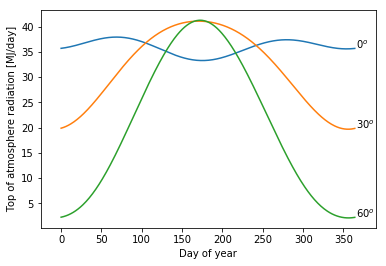

In [4]:
days = np.arange(365)
lats = [0,30,60]

# Empty matrix to hold output
matKE = np.zeros((len(days),len(lats)))*np.nan

# For loops:
plt.figure(1)
for l in np.arange(len(lats)):
    for d in np.arange(len(days)):
        curDay = days[d]
        curLat = lats[l]*np.pi/180
        matKE[d,l] = getKE(curDay,curLat)
    plt.plot(days,matKE[:,l])
    plt.text(366,matKE[d,l],'%d$^o$'%lats[l])
    plt.xlim(-25,365+25)
plt.xlabel('Day of year')
plt.ylabel('Top of atmosphere radiation [MJ/day]')        
plt.show()

## Net Radiation
Given that we have the radiation above the atmosphere, we must account for the transmissivitiy of the atmosphere ($\tau_{atm}$), of clouds ($\tau_{C}$) and of forest/plant cover ($\tau_{F}$). This can be expressed as 

$$ K_{in} = \tau_{atm}\tau_{C}\tau_{F}K_{ET} $$

($\tau_{atm}$), it's cloud cover ($\tau_{cc}$), and any vegetation ($\tau_{veg}$). All these things can decrease radiation and can be estimated from Appendix D or Chapter 5.

For the context of this example we'll assume $\tau_{total}=0.75$, i.e. $K_{in}$ = 0.75 $K_{ET}$; but see Appendix D for more detailed calculation methods. Finally, the net shortwave radiation is determined by the albedo of the surface as:

$$ K_{net} = K_{In}-K_{out} = (1-a) K_{in} $$

For the longwave radiation, we have a similar balance as

$$ L_{net} = L_{In}-L_{out} $$

where the incoming and outgoing longwave energy is a function of the temperature (following Stephan-Boltzman).

$$ L_{in} = \epsilon_{atm} \sigma T_{atm}^4 $$

$$ L_{in} = \epsilon_{surf} \sigma T_{surf}^4 $$

with $\epsilon$ the emisivity of the media. Here we adjust the emisivity of the atmosphere based on the vapor pressure as:

$$ \epsilon = 0.83 - 0.18 \exp(-1.54 e_a) $$

where $e_a$ is the atmospheric vapor pressure

In [3]:
# Surfce Condtions and Constants
albedo = 0.5 # For snow
tAir = 40
rh = 0.6
tSurf = 0
tau = 0.75

# Calcuate net shortwave
def getKnet(doy,lat,albedo,tau):
    KE = getKE(doy,lat)
    Knet = (1-albedo) * tau *KE 
    return Knet
print('Knet',getKnet(doy,lat,albedo,tau))

# Incoming Longwave
def getLnet(tAir,tSurf,rh):
    sb_constant = 4.90 * 10**-9 # [MJ/m2 k4 day]
    e_atm = 0.611*np.exp(17.3*tAir/(tAir+237.3))*rh
    eps_atm = 0.83 - 0.18*np.exp(-1.54*e_atm)
    # Incoming longwave
    Lin = eps_atm * sb_constant * (tAir+273.15)**4
    # Outgoing Longwave
    eps_snow = 1
    Lout = eps_snow * sb_constant * (tSurf+273.15)**4
    # Net Longwave
    Lnet = Lin - Lout
    return Lnet
print('Lnet',getLnet(tAir,tSurf,rh))

# Total Net Radiation 
def getRnet(doy,lat,albedo,tau, tAir,tSurf,rh):
    Rnet = getKnet(doy,lat,albedo,tau) + getLnet(tAir,tSurf,rh)
    return Rnet
print('Net Radiation:',getRnet(doy,lat,albedo,tau, tAir,tSurf,rh))


Knet 11.056134522584061
Lnet 11.823357720582674
Net Radiation: 22.879492243166737


# Variation in Net Radiation
Now we want to explore how air temp, surface temp, and relative humdiity influence net radiation. 

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


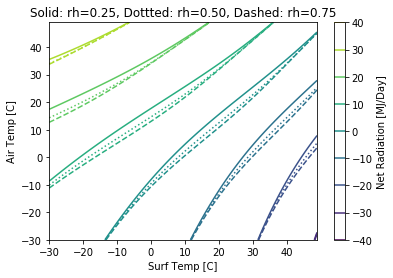

In [4]:
v1 = np.arange(-30,50,1); # Tair
v2 = np.arange(-30,50,1); # Tsurf
v3 = np.array([0.25, 0.5, 0.75]); # Relative Humidity 
outMat = np.zeros((len(v1),len(v2),len(v3)))

# Evaluate Different Condtions
for i in np.arange(len(v1)):
    for j in np.arange(len(v2)):
        for k in np.arange(len(v3)):
            cV1 = v1[i]
            cV2 = v2[j]
            cV3 = v3[k]
            outMat[i,j,k] = getRnet(doy,lat,albedo,tau,cV1,cV2,cV3)

# Make A Plot
plt.figure(2)
plt.contour(v1,v2,outMat[:,:,0],label='Tau')
plt.contour(v1,v2,outMat[:,:,1],linestyles=':')
plt.contour(v1,v2,outMat[:,:,2],linestyles='--')
plt.xlabel('Surf Temp [C]'); plt.ylabel('Air Temp [C]')
plt.title('Solid: rh=%.2f, Dottted: rh=%.2f, Dashed: rh=%.2f'% (v3[0],v3[1],v3[2]))
plt.colorbar(label='Net Radiation [MJ/Day]');
plt.show()